In [72]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# TensorFlow / Keras Imports
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Bidirectional,
    TimeDistributed, Dense, Flatten, Dropout, BatchNormalization, Reshape
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Preprocessing

In [73]:
df = pd.read_csv("data.csv")

In [74]:
df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
df.set_index("ts", inplace=True)  # Set timestamp as index

/tmp/ipykernel_7982/3326812862.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample("M").mean()  # Change "W" to "M" for monthly


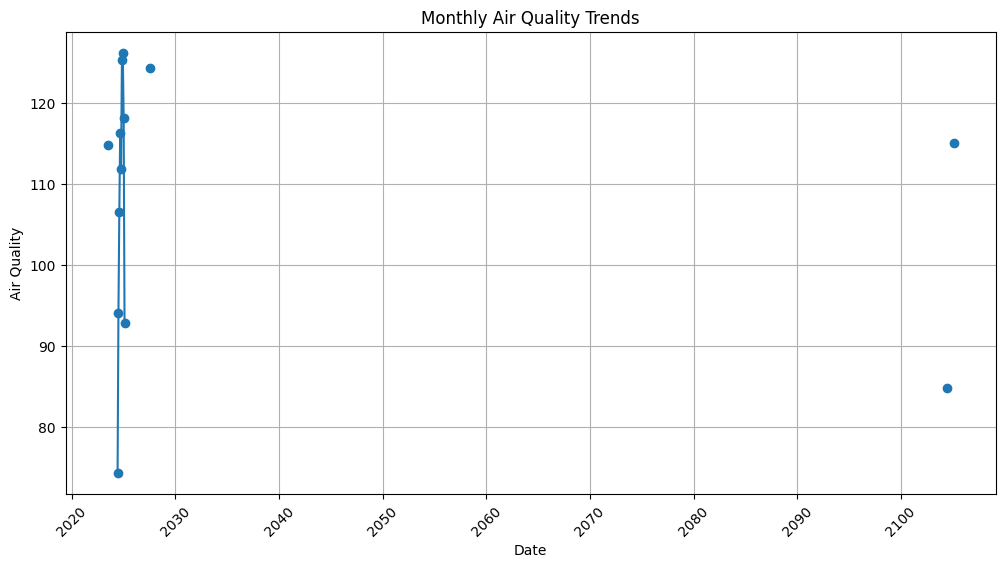

In [75]:
import pandas as pd
import matplotlib.pyplot as plt  

# Resample weekly or monthly (choose based on requirement)
df_resampled = df.resample("M").mean()  # Change "W" to "M" for monthly

plt.figure(figsize=(12, 6))  
plt.plot(df_resampled.index, df_resampled["Air Quality"], marker="o", linestyle="-")  
plt.xlabel("Date")  
plt.ylabel("Air Quality")  
plt.title("Monthly Air Quality Trends")  
plt.xticks(rotation=45)  
plt.grid()  
plt.show()  


In [76]:
df = df[(df.index < "2026-01-01") & (df.index > "2024-01-01")]


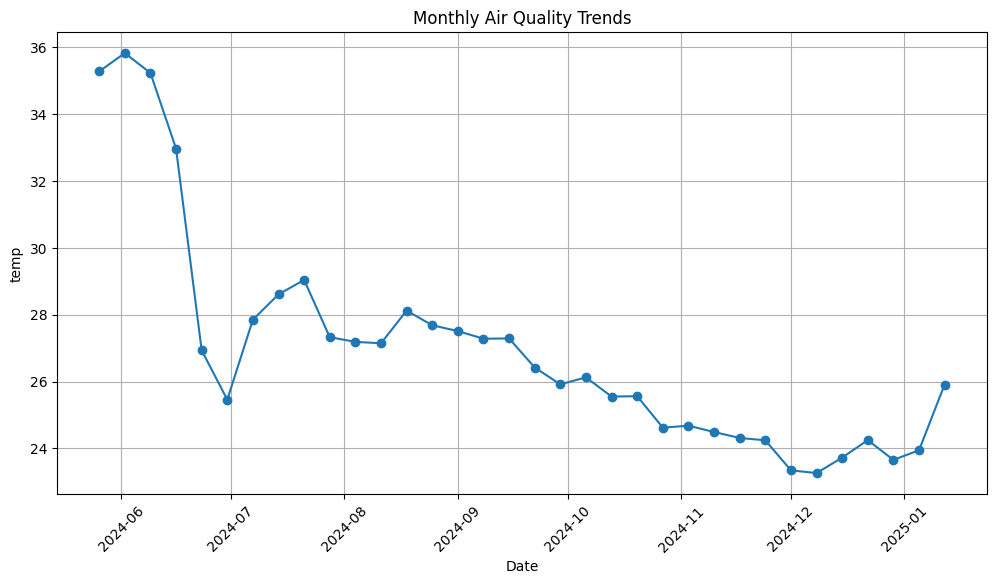

In [77]:
df_resampled = df.resample("W").mean()  # Change "W" to "M" for monthly

plt.figure(figsize=(12, 6))  
plt.plot(df_resampled.index, df_resampled["Temp"], marker="o", linestyle="-")  
plt.xlabel("Date")  
plt.ylabel("temp")  
plt.title("Monthly Air Quality Trends")  
plt.xticks(rotation=45)  
plt.grid()  
plt.show()  

In [78]:
# Create a copy of the dataframe
df2 = df.copy()
df2.shape

(589168, 10)

In [79]:
df2['month'] = df2.index.month


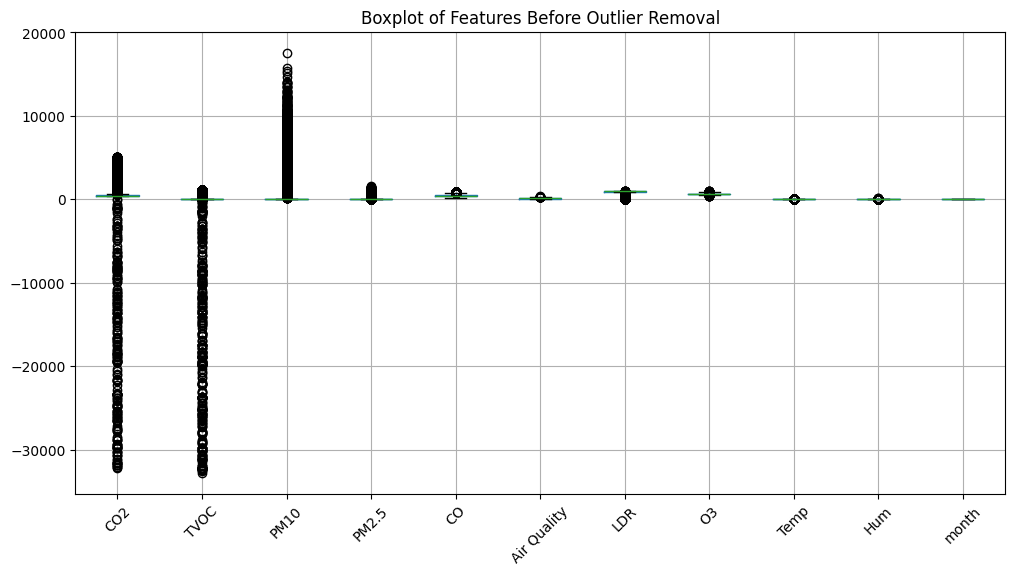

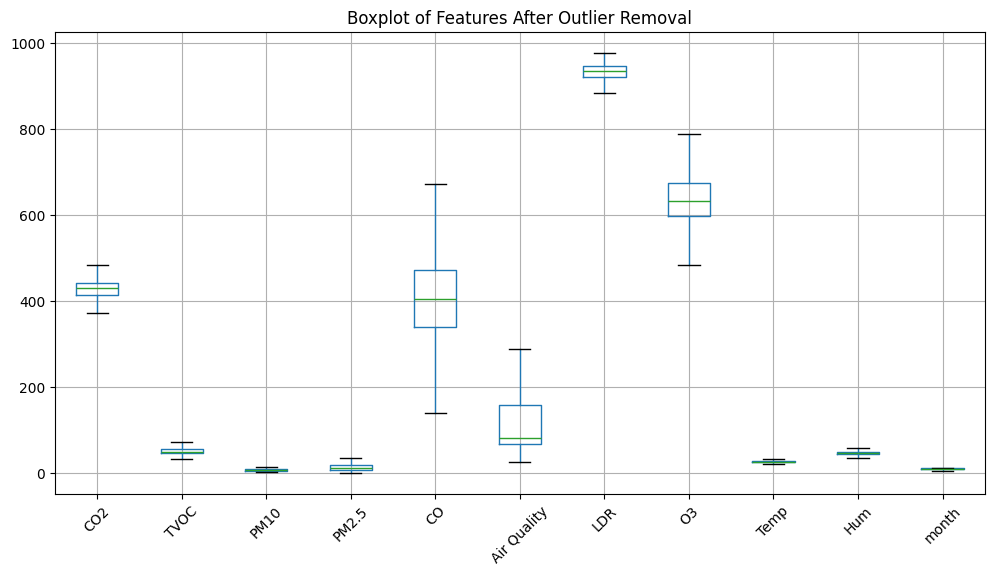

In [80]:
df2_original = df2.copy()

# Get numerical columns list
num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()

# Plot the boxplot of the original data (with outliers)
plt.figure(figsize=(12, 6))
df2_original[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features Before Outlier Removal")
plt.show()

# ------------------------------------------------
# Now, remove outliers from df2 and plot again if needed

# Initialize a variable to track the number of rows (for reference)
previous_rows = df2.shape[0]

while True:
    # Calculate Q1, Q3, and IQR for numerical columns
    Q1 = df2[num_cols].quantile(0.25)
    Q3 = df2[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Determine outlier condition for each cell
    outliers = ((df2[num_cols] < (Q1 - 1.5 * IQR)) | (df2[num_cols] > (Q3 + 1.5 * IQR)))

    # Remove rows with any outliers
    new_df2 = df2[~outliers.any(axis=1)]

    # Check if no rows were removed
    current_rows = new_df2.shape[0]
    if current_rows == previous_rows:
        break  # Stop the loop if no more outliers were removed

    # Update df2 and previous_rows for the next iteration
    df2 = new_df2.copy()
    previous_rows = current_rows

# Optionally, plot the cleaned data boxplot
plt.figure(figsize=(12, 6))
df2[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features After Outlier Removal")
plt.show()


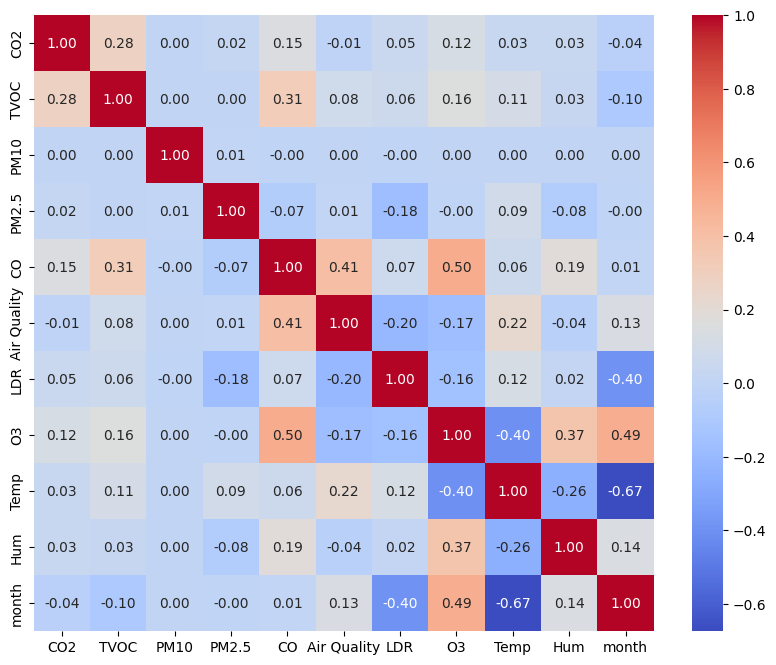

In [81]:
corr_matrix = df2.corr()  # No need to drop anything

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [82]:
def scale_features(data, scaler=None):
    """
    Scales features using StandardScaler. If a scaler is provided, it transforms the data;
    otherwise, it fits and transforms the data using a new StandardScaler instance.
    
    Parameters:
    X_train (array-like): Feature matrix.
    scaler (StandardScaler, optional): Pre-fitted StandardScaler instance. Defaults to None.
    
    Returns:
    X_train_scaled (np.array): Scaled feature matrix.
    scaler (StandardScaler): StandardScaler instance used.
    """
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)
    
    return data_scaled, scaler

In [83]:

def encode_labels(y):
    """
    Encodes categorical labels into integers and ensures a 1D array.
    
    Parameters:
    y_train (array-like): Original labels.
    
    Returns:
    y_train_encoded (np.array): Encoded 1D array of labels.
    label_encoder (LabelEncoder): Fitted LabelEncoder instance.
    """
    y = np.ravel(y)  # Ensure 1D
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    return y_encoded.squeeze(), le

def generate_sequences(X_train, y_train_encoded, sequence_length=60, target_length=60):
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X_train) - sequence_length - target_length + 1):
        X_sequences.append(X_train[i:i+sequence_length])
        y_sequences.append(y_train_encoded[i+sequence_length:i+sequence_length+target_length])
    
    return np.array(X_sequences), np.array(y_sequences)

In [84]:
X=df2.drop(axis=1,columns="Temp")
y=df2[["Temp"]]
y_encoded, le = encode_labels(y)

In [85]:
X.shape, y.shape

((289020, 10), (289020, 1))

In [86]:
X , scaler = scale_features(X)

In [87]:
X.shape

(289020, 10)

In [88]:
y_encoded.shape

(289020,)

In [89]:
X_sequences, y_sequences = generate_sequences(X, y_encoded)
X_sequences.shape, y_sequences.shape

((288901, 60, 10), (288901, 60))

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42, shuffle=True)

In [91]:
X_test.shape

(57781, 60, 10)

In [92]:
X_train.shape, y_train.shape

((231120, 60, 10), (231120, 60))

In [93]:
import tensorflow as tf 
# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float16)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float16)

In [94]:
X_train_tensor.shape, y_train_tensor.shape

(TensorShape([231120, 60, 10]), TensorShape([231120, 60]))

# Model building

- using X_train_tensor (298463, 60, 10), y_train_tensor (298463, 60) for modeling 

In [113]:
epochs_count = 3
def r_squared(y_true, y_pred):
    """
    Calculate the R-squared metric.
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


#### DCNN_model

In [96]:
def build_1DCNN_reg(sequence_length=60, no_features=10):
    """
    Builds and returns a 1D CNN model for time-series regression.
    
    Parameters:
    - sequence_length (int): Number of input timesteps
    - no_features (int): Number of input features
    
    Returns:
    - model (Sequential): Compiled Keras model
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # CNN Feature Extraction
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Regression Output
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dense(1, activation='linear'))  # Regression output
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error',r_squared])
    
    return model


In [97]:
# Build and train the model
DCNN_model_reg = build_1DCNN_reg()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

# Reshape y_train_tensor to (batch_size, sequence_length, 1) for regression
y_train_tensor_reshaped = np.expand_dims(y_train_tensor, axis=-1)

history = DCNN_model_reg.fit(
    X_train_tensor,
    y_train_tensor_reshaped,
    validation_split=0.1,
    epochs=epochs_count,
    verbose=1,
    batch_size=128,
    callbacks=callbacks
)

# Save the trained model
DCNN_model_reg.save("models/DCNN_model_reg.keras")

Epoch 1/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 987.0706 - mean_absolute_error: 22.1779 - r_squared: -0.8362 - val_loss: 155.5124 - val_mean_absolute_error: 9.4377 - val_r_squared: 0.7101
Epoch 2/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 190.6734 - mean_absolute_error: 10.4995 - r_squared: 0.6422 - val_loss: 150.5451 - val_mean_absolute_error: 9.1361 - val_r_squared: 0.7193
Epoch 3/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 170.2666 - mean_absolute_error: 9.8760 - r_squared: 0.6824 - val_loss: 164.8297 - val_mean_absolute_error: 9.6962 - val_r_squared: 0.6936


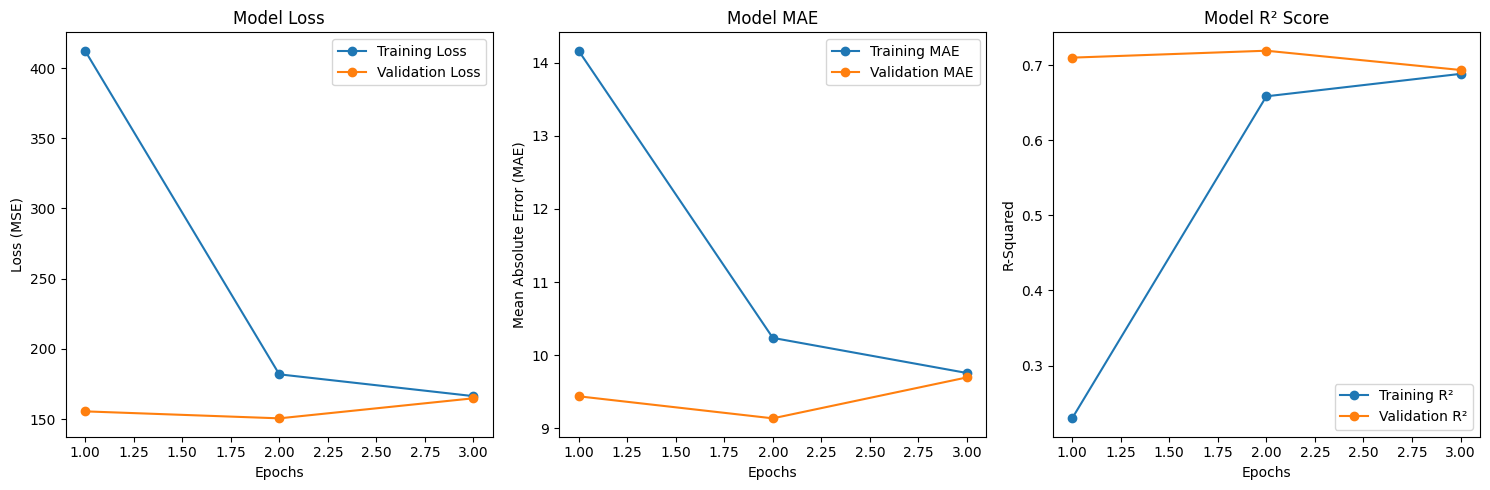

In [98]:

import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict["loss"], label="Training Loss", marker="o")
plt.plot(epochs, history_dict["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Model Loss")

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict["mean_absolute_error"], label="Training MAE", marker="o")
plt.plot(epochs, history_dict["val_mean_absolute_error"], label="Validation MAE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.title("Model MAE")

# Plot R-Squared
plt.subplot(1, 3, 3)
plt.plot(epochs, history_dict["r_squared"], label="Training R²", marker="o")
plt.plot(epochs, history_dict["val_r_squared"], label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R-Squared")
plt.legend()
plt.title("Model R² Score")

plt.tight_layout()
plt.show()



#### DNN_model

In [99]:
def build_DNN_reg(sequence_length=60, no_features=10):
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(128, activation='relu'),
        
        # Regression output
        Dense(sequence_length, activation='linear'),  # Predicts one value per timestep
        Reshape((sequence_length, 1))  # Reshape output to match time-series format
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error',r_squared])  # Removed r_squared if undefined
    
    return model

In [100]:
# Build and train the model
DNN_model_reg = build_DNN_reg()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)
]

# Reshape y_train_tensor to (batch_size, sequence_length, 1) for regression
y_train_tensor_reshaped = np.expand_dims(y_train_tensor, axis=-1)

history = DNN_model_reg.fit(
    X_train_tensor,
    y_train_tensor_reshaped,
    validation_split=0.1,
    epochs=epochs_count,
    verbose=1,
    batch_size=128,
    callbacks=callbacks
)

# Save the trained model
DNN_model_reg.save("models/DNN_model_reg.keras")

Epoch 1/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 719.6167 - mean_absolute_error: 17.8586 - r_squared: -0.3605 - val_loss: 146.4814 - val_mean_absolute_error: 8.9956 - val_r_squared: 0.7266
Epoch 2/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 160.1823 - mean_absolute_error: 9.5713 - r_squared: 0.6992 - val_loss: 127.7161 - val_mean_absolute_error: 8.4885 - val_r_squared: 0.7615
Epoch 3/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 145.5488 - mean_absolute_error: 9.0990 - r_squared: 0.7290 - val_loss: 117.5740 - val_mean_absolute_error: 8.1483 - val_r_squared: 0.7805


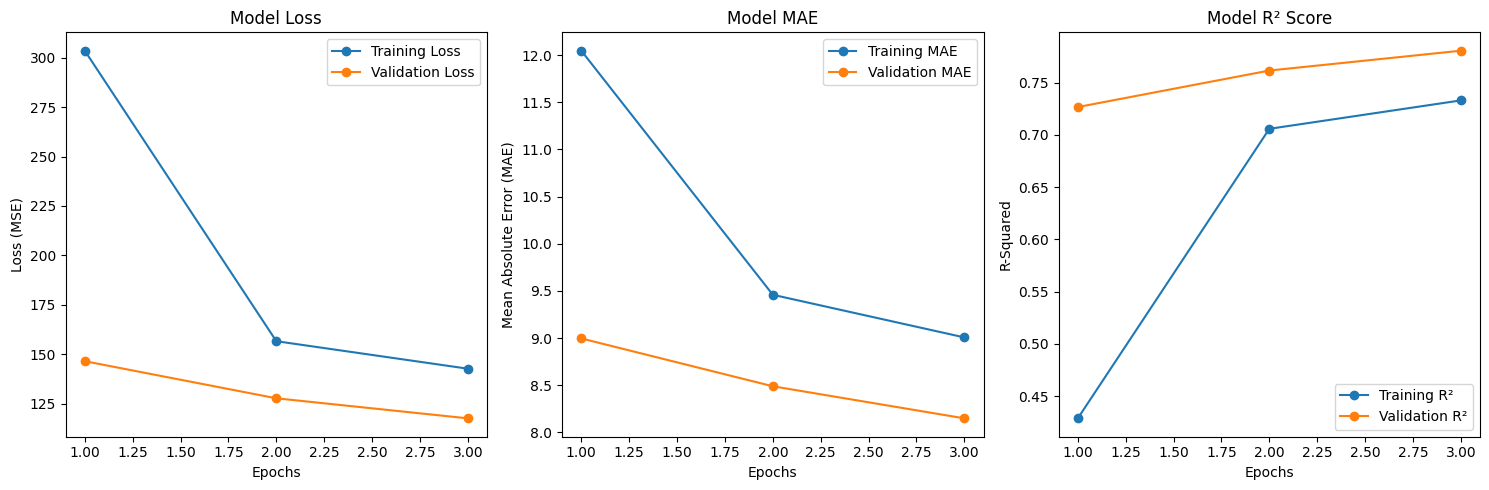

In [101]:

import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict["loss"], label="Training Loss", marker="o")
plt.plot(epochs, history_dict["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Model Loss")

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict["mean_absolute_error"], label="Training MAE", marker="o")
plt.plot(epochs, history_dict["val_mean_absolute_error"], label="Validation MAE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.title("Model MAE")

# Plot R-Squared
plt.subplot(1, 3, 3)
plt.plot(epochs, history_dict["r_squared"], label="Training R²", marker="o")
plt.plot(epochs, history_dict["val_r_squared"], label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R-Squared")
plt.legend()
plt.title("Model R² Score")

plt.tight_layout()
plt.show()



#### RNN_model

In [102]:
def build_RNN_model_reg(sequence_length=60, no_features=10):
    """
    Builds and returns an RNN model for time-series regression.
    
    Parameters:
    - sequence_length (int): Number of input timesteps (60)
    - no_features (int): Number of input features (10)
    
    Returns:
    - model (Sequential): Compiled Keras model
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # Stacked LSTM layers with return_sequences=True
        LSTM(128, return_sequences=True, activation='tanh'),
        LSTM(64, return_sequences=True, activation='tanh'),
        
        # Regression output
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dense(1, activation='linear'))  # Regression output
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error',r_squared])
    
    return model

In [103]:

RNN_model_reg = build_RNN_model_reg()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

# Reshape y_train_tensor to (batch_size, sequence_length, 1) for regression
y_train_tensor_reshaped = np.expand_dims(y_train_tensor, axis=-1)

history = RNN_model_reg.fit(
    X_train_tensor,
    y_train_tensor_reshaped,
    validation_split=0.1,
    epochs=epochs_count,
    verbose=1,
    batch_size=128,
    callbacks=callbacks  # Removed sample_weight
)

# Save the trained model
RNN_model_reg.save("models/RNN_model_reg.keras")

Epoch 1/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 920.9975 - mean_absolute_error: 21.7278 - r_squared: -0.7267 - val_loss: 177.9272 - val_mean_absolute_error: 9.9956 - val_r_squared: 0.6686
Epoch 2/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 165.9573 - mean_absolute_error: 9.5813 - r_squared: 0.6891 - val_loss: 159.5036 - val_mean_absolute_error: 9.4705 - val_r_squared: 0.7021
Epoch 3/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 147.6597 - mean_absolute_error: 9.0328 - r_squared: 0.7232 - val_loss: 142.3326 - val_mean_absolute_error: 8.9253 - val_r_squared: 0.7347


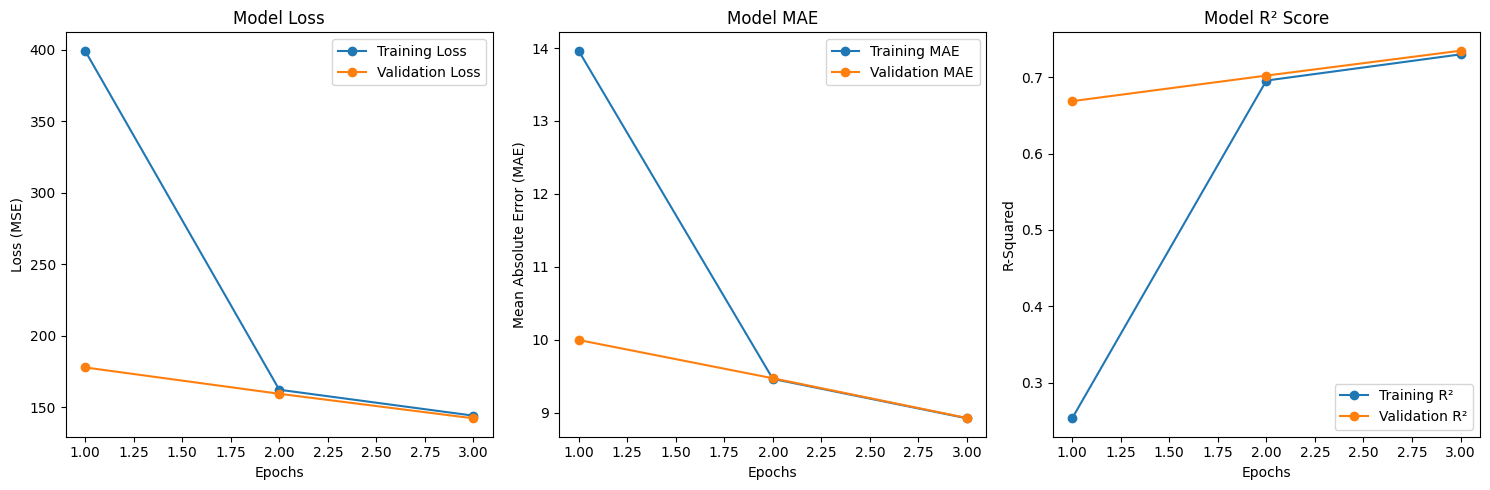

In [104]:

import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict["loss"], label="Training Loss", marker="o")
plt.plot(epochs, history_dict["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Model Loss")

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict["mean_absolute_error"], label="Training MAE", marker="o")
plt.plot(epochs, history_dict["val_mean_absolute_error"], label="Validation MAE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.title("Model MAE")

# Plot R-Squared
plt.subplot(1, 3, 3)
plt.plot(epochs, history_dict["r_squared"], label="Training R²", marker="o")
plt.plot(epochs, history_dict["val_r_squared"], label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R-Squared")
plt.legend()
plt.title("Model R² Score")

plt.tight_layout()
plt.show()



#### lstm_model

In [105]:
def build_lstm_model_reg(sequence_length=60, no_features=10):
    """
    Standard unidirectional LSTM model for sequence regression.
    Processes sequences in forward direction only.
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # First LSTM layer
        LSTM(128, return_sequences=True, 
             dropout=0.2, recurrent_dropout=0.1),
        
        # Second LSTM layer
        LSTM(64, return_sequences=True),
        
        # Regression head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.2)),
        TimeDistributed(Dense(1, activation='linear'))  # Regression output
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error',r_squared])
    
    return model


In [106]:
lstm_model_reg = build_lstm_model_reg()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

# Reshape y_train_tensor to (batch_size, sequence_length, 1) for regression
y_train_tensor_reshaped = np.expand_dims(y_train_tensor, axis=-1)

history = lstm_model_reg.fit(
    X_train_tensor,
    y_train_tensor_reshaped,
    validation_split=0.1,
    epochs=epochs_count,
    verbose=1,
    batch_size=128,
    callbacks=callbacks  # Removed sample_weight
)

# Save the trained model
lstm_model_reg.save("models/lstm_model_reg.keras")

Epoch 1/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 129s 74ms/step - loss: 1048.6586 - mean_absolute_error: 24.4327 - r_squared: -0.9558 - val_loss: 197.6013 - val_mean_absolute_error: 10.6745 - val_r_squared: 0.6319
Epoch 2/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 121s 75ms/step - loss: 235.4595 - mean_absolute_error: 11.6933 - r_squared: 0.5584 - val_loss: 169.9958 - val_mean_absolute_error: 9.6387 - val_r_squared: 0.6829
Epoch 3/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 123s 75ms/step - loss: 216.1738 - mean_absolute_error: 11.1455 - r_squared: 0.5925 - val_loss: 154.8299 - val_mean_absolute_error: 9.2704 - val_r_squared: 0.7114


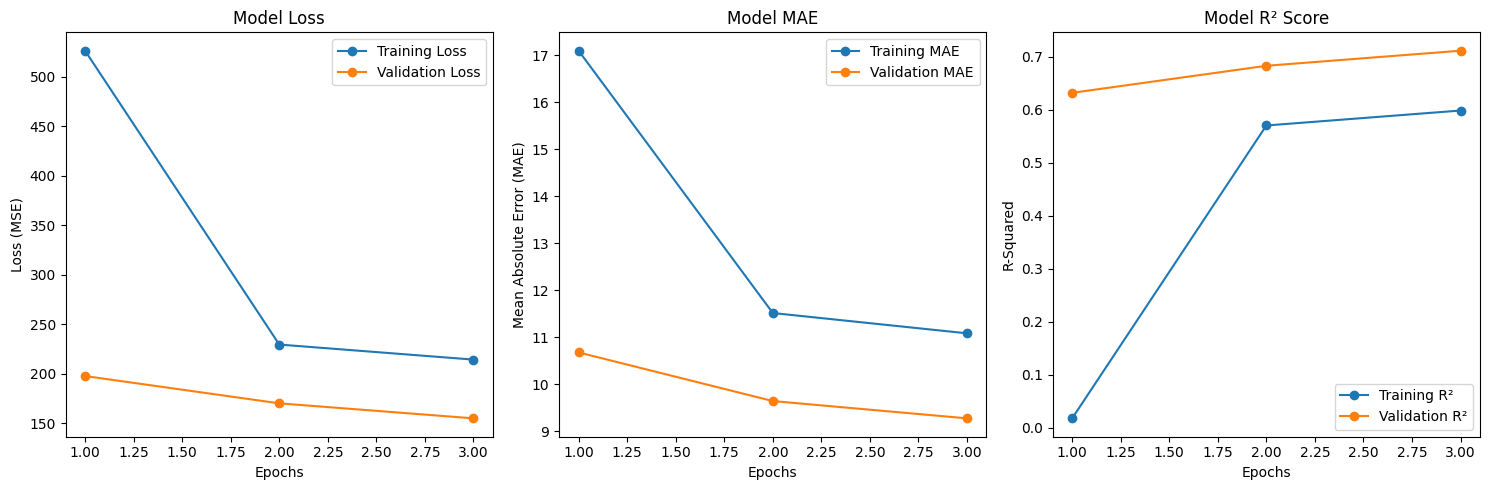

In [107]:

import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict["loss"], label="Training Loss", marker="o")
plt.plot(epochs, history_dict["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Model Loss")

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict["mean_absolute_error"], label="Training MAE", marker="o")
plt.plot(epochs, history_dict["val_mean_absolute_error"], label="Validation MAE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.title("Model MAE")

# Plot R-Squared
plt.subplot(1, 3, 3)
plt.plot(epochs, history_dict["r_squared"], label="Training R²", marker="o")
plt.plot(epochs, history_dict["val_r_squared"], label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R-Squared")
plt.legend()
plt.title("Model R² Score")

plt.tight_layout()
plt.show()



#### bilstm_model

In [108]:
def build_bilstm_reg(sequence_length=60, no_features=10):
    """
    Bidirectional LSTM model for time-series regression.
    
    Parameters:
    - sequence_length (int): Number of input timesteps.
    - no_features (int): Number of input features.
    
    Returns:
    - model (Sequential): Compiled Keras model.
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),

        # BiLSTM Feature Extraction
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        BatchNormalization(),
        Bidirectional(LSTM(32, return_sequences=True, dropout=0.1)),
        BatchNormalization(),
        Dropout(0.2),

        # Regression Output
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dense(1, activation='linear'))  # Regression output
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error', r_squared])
    
    return model

In [109]:

# Build and train the model
bilstm_reg = build_bilstm_reg()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

# Reshape y_train_tensor to (batch_size, sequence_length, 1) for regression
y_train_tensor_reshaped = np.expand_dims(y_train_tensor, axis=-1)

history = bilstm_reg.fit(
    X_train_tensor,
    y_train_tensor_reshaped,
    validation_split=0.1,
    epochs=epochs_count,
    verbose=1,
    batch_size=128,
    callbacks=callbacks
)

# Save the trained model
bilstm_reg.save("models/bilstm_model_reg.keras")

Epoch 1/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 186s 110ms/step - loss: 923.3604 - mean_absolute_error: 21.4175 - r_squared: -0.7014 - val_loss: 176.8286 - val_mean_absolute_error: 10.0021 - val_r_squared: 0.6704
Epoch 2/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 179s 110ms/step - loss: 213.1386 - mean_absolute_error: 11.1044 - r_squared: 0.5996 - val_loss: 158.7237 - val_mean_absolute_error: 9.4441 - val_r_squared: 0.7042
Epoch 3/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 179s 110ms/step - loss: 195.9615 - mean_absolute_error: 10.6134 - r_squared: 0.6320 - val_loss: 150.2818 - val_mean_absolute_error: 9.1781 - val_r_squared: 0.7200


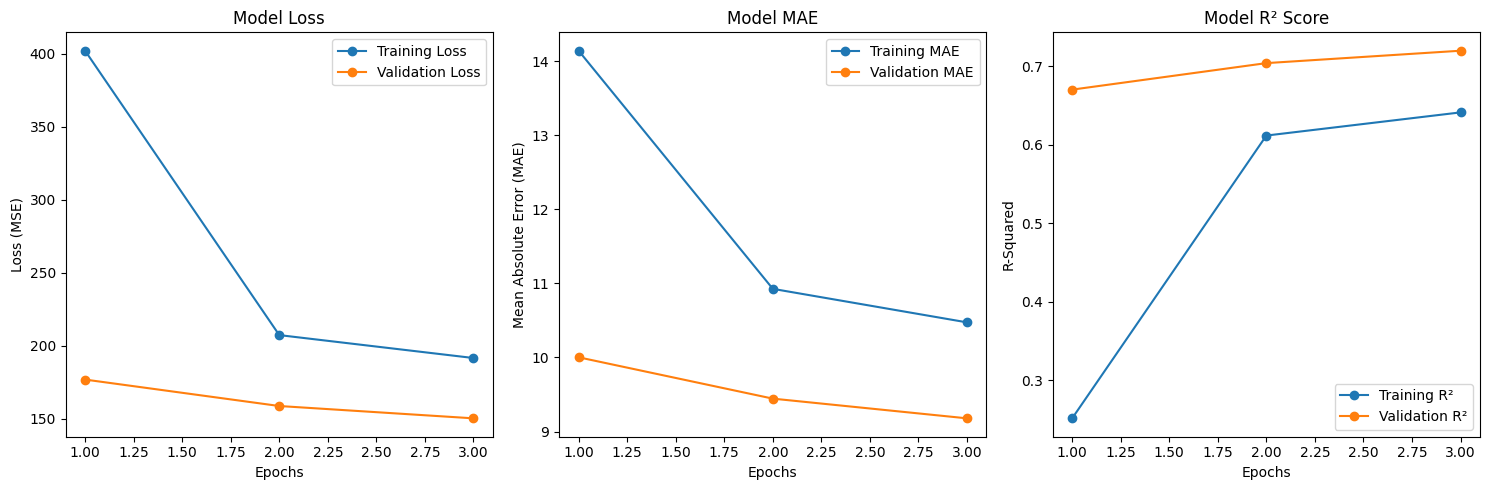

In [110]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict["loss"], label="Training Loss", marker="o")
plt.plot(epochs, history_dict["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Model Loss")

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict["mean_absolute_error"], label="Training MAE", marker="o")
plt.plot(epochs, history_dict["val_mean_absolute_error"], label="Validation MAE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.title("Model MAE")

# Plot R-Squared
plt.subplot(1, 3, 3)
plt.plot(epochs, history_dict["r_squared"], label="Training R²", marker="o")
plt.plot(epochs, history_dict["val_r_squared"], label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R-Squared")
plt.legend()
plt.title("Model R² Score")

plt.tight_layout()
plt.show()


#### CNN_BILSTM

In [28]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    """
    Calculate the R-squared metric.
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def build_CNN_BILSTM_reg(sequence_length=60, no_features=10):
    """
    Build a CNN + BiLSTM model for regression.
    The model outputs a continuous value for each time step.
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # CNN Feature Extraction Block
        Conv1D(128, kernel_size=5, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(64, kernel_size=3, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Bidirectional LSTM Temporal Modeling
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # Regression Head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.1)),
        TimeDistributed(Dense(1, activation='linear'))  # Regression output
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error',r_squared,])
    return model


In [29]:
# Build the regression model
CNN_BILSTM_reg = build_CNN_BILSTM_reg()

##### R² (Coefficient of Determination)

R² measures how well your model explains the variance in the target variable.

It ranges from **negative infinity** to **1**:

- **1** → Perfect fit (your model explains 100% of the variance).  
- **0** → Model explains nothing (as good as predicting the mean).  
- **Negative** → Worse than a simple mean prediction.  


In [ ]:



callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

# Reshape y_train_tensor to (batch_size, sequence_length, 1) for regression
y_train_tensor_reshaped = np.expand_dims(y_train_tensor, axis=-1)

history = CNN_BILSTM_reg.fit(
    X_train_tensor,
    y_train_tensor_reshaped,
    validation_split=0.1,
    epochs=epochs_count,
    verbose=1,
    batch_size=128,
    callbacks=callbacks
)

# Save the trained model
CNN_BILSTM_reg.save("models/CNN_BILSTM_reg.keras")

2025-03-17 07:24:20.177912: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499219200 exceeds 10% of free system memory.


Epoch 1/3


I0000 00:00:1742189070.839734    8132 cuda_dnn.cc:529] Loaded cuDNN version 90300


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 248s 145ms/step - loss: 797.9313 - mean_absolute_error: 19.2471 - r_squared: -0.4968 - val_loss: 143.0986 - val_mean_absolute_error: 8.9611 - val_r_squared: 0.7333
Epoch 2/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 239s 147ms/step - loss: 159.9864 - mean_absolute_error: 9.5060 - r_squared: 0.6991 - val_loss: 122.0956 - val_mean_absolute_error: 8.2338 - val_r_squared: 0.7724
Epoch 3/3
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 237s 146ms/step - loss: 139.4802 - mean_absolute_error: 8.8665 - r_squared: 0.7386 - val_loss: 103.4103 - val_mean_absolute_error: 7.5295 - val_r_squared: 0.8069


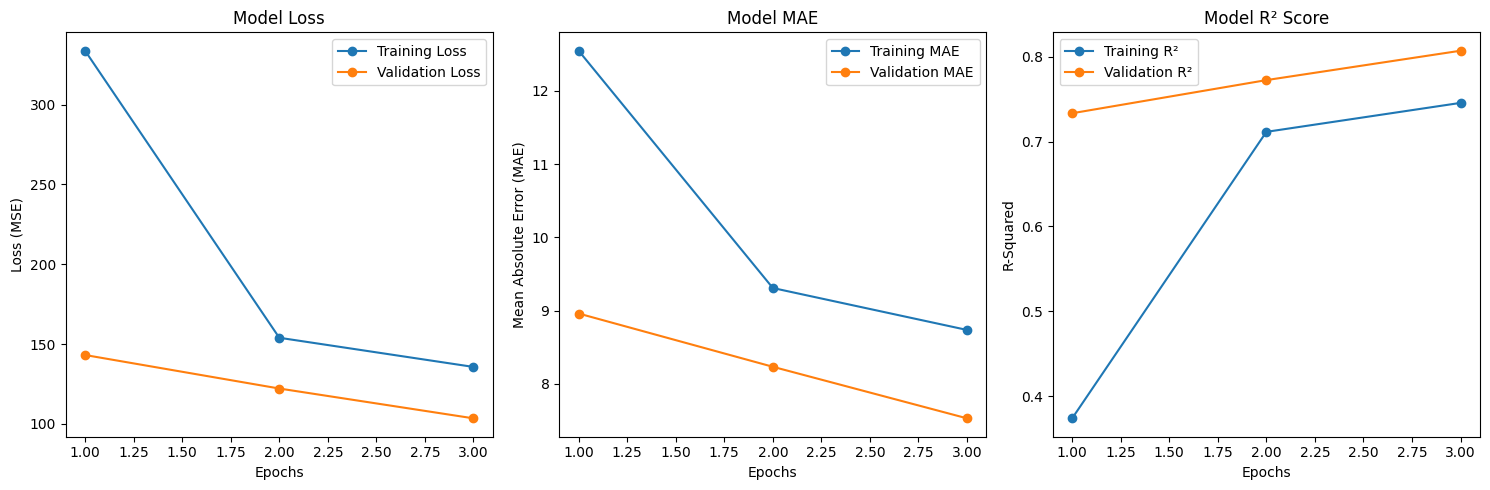

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict["loss"], label="Training Loss", marker="o")
plt.plot(epochs, history_dict["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Model Loss")

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict["mean_absolute_error"], label="Training MAE", marker="o")
plt.plot(epochs, history_dict["val_mean_absolute_error"], label="Validation MAE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.title("Model MAE")

# Plot R-Squared
plt.subplot(1, 3, 3)
plt.plot(epochs, history_dict["r_squared"], label="Training R²", marker="o")
plt.plot(epochs, history_dict["val_r_squared"], label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R-Squared")
plt.legend()
plt.title("Model R² Score")

plt.tight_layout()
plt.show()


#### Evaluation

In [ ]:
# X_test, y_test = generate_sequences(X_test, y_test)

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model_reg(model, X_test_sequences, y_test_sequences):
    """
    Computes regression evaluation metrics: MSE, MAE, and R²-score.
    
    Parameters:
    - model: Trained regression model.
    - X_test_sequences: Test data sequences.
    - y_test_sequences: True regression values.
    
    Returns:
    - metrics (dict): Dictionary containing MSE, MAE, and R²-score.
    """
    predictions = model.predict(X_test_sequences)
    
    # Ensure shape consistency for evaluation
    y_test_sequences = np.squeeze(y_test_sequences)
    predictions = np.squeeze(predictions)

    # Compute regression metrics
    mse = mean_squared_error(y_test_sequences, predictions)
    mae = mean_absolute_error(y_test_sequences, predictions)
    r2 = r2_score(y_test_sequences, predictions)

    metrics = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'R² Score': r2
    }
    
    return metrics


In [117]:
from tensorflow.keras.models import load_model

# Define model paths with "_reg" suffix
model_paths = [
    "models/bilstm_model_reg.keras",
    "models/DCNN_model_reg.keras",
    "models/lstm_model_reg.keras",
    "models/CNN_BILSTM_reg.keras",
    "models/DNN_model_reg.keras",
    "models/RNN_model_reg.keras"
]
custom_objects = {"r_squared": r_squared}

# Load models into a dictionary
models = {path.split("/")[-1]: load_model(path, custom_objects=custom_objects) for path in model_paths}

# Access models using their filenames
CNN_BILSTM_reg = models["CNN_BILSTM_reg.keras"]
bilstm_model_reg = models["bilstm_model_reg.keras"]
DCNN_model_reg = models["DCNN_model_reg.keras"]
lstm_model_reg = models["lstm_model_reg.keras"]
DNN_model_reg = models["DNN_model_reg.keras"]
RNN_model_reg = models["RNN_model_reg.keras"]


In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dictionary of models
models = {
    'bilstm_model_reg': bilstm_model_reg,
    'DCNN_model_reg': DCNN_model_reg,
    'lstm_model_reg': lstm_model_reg,
    'CNN_BILSTM_reg': CNN_BILSTM_reg,
    'DNN_model_reg': DNN_model_reg,
    'RNN_model_reg': RNN_model_reg
}

# Initialize results dictionaries
results_test = {}
results_train = {}

def evaluate_model_reg(model, X, y):
    """
    Evaluates a regression model using MAE, MSE, and R² score.
    
    Parameters:
    - model: Trained regression model.
    - X: Input features.
    - y: True target values.
    
    Returns:
    - metrics (dict): Dictionary containing MAE, MSE, and R² score.
    """
    predictions = model.predict(X)

    # Reshape if predictions have 3 dimensions (batch_size, seq_length, num_outputs)
    if predictions.ndim == 3:
        predictions = predictions.reshape(predictions.shape[0], -1)
    
    if y.ndim == 3:
        y = y.reshape(y.shape[0], -1)

    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    return {
        'MAE': mae,
        'MSE': mse,
        'R² Score': r2
    }

# Evaluate each model
for name, model in models.items():
    results_test[name] = evaluate_model_reg(model, X_test, y_test)
    results_train[name] = evaluate_model_reg(model, X_train, y_train)


1806/1806 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 212s 29ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 7s 954us/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 160s 22ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 194s 27ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 6s 796us/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step


In [120]:
with open("History/results_test_reg.pkl", "wb") as f:
    pickle.dump(results_test, f)

with open("History/results_train_reg.pkl", "wb") as f:
    pickle.dump(results_train, f)

In [121]:
with open("History/results_test.pkl", "rb") as f:
    results_test_reg = pickle.load(f)

with open("History/results_train.pkl", "rb") as f:
    results_train_reg = pickle.load(f)

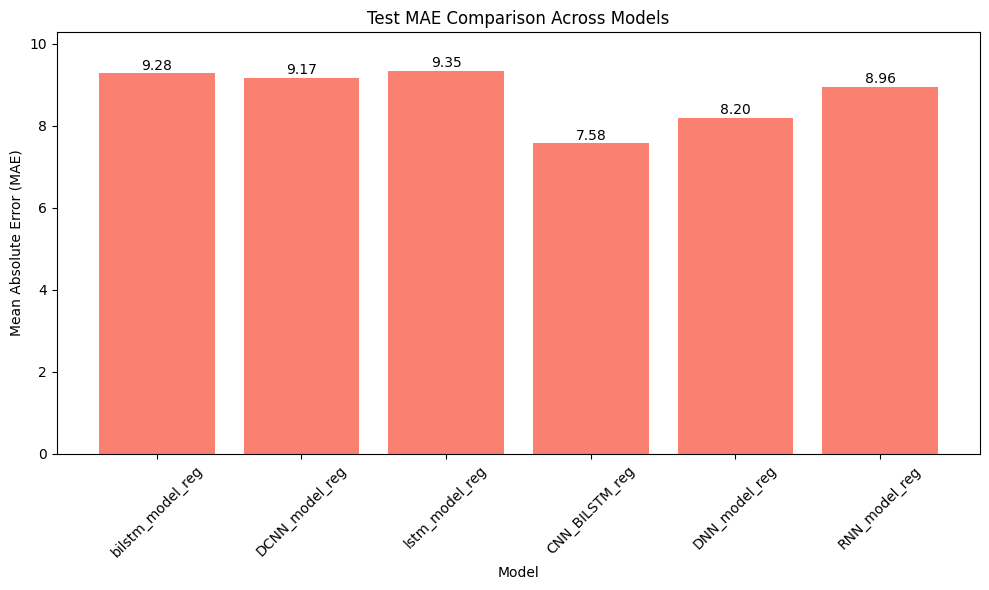

In [122]:

# Extract model names and their corresponding MAE scores
model_names = list(results_test.keys())
mae_scores = [metrics['MAE'] for metrics in [results_test[m] for m in model_names]]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mae_scores, color='salmon')

plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Test MAE Comparison Across Models')
plt.ylim(0, max(mae_scores) * 1.1)  # Adjusting the y-axis to fit the highest value

# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.005, f"{yval:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)  # Rotate model names for better readability
plt.tight_layout()
plt.show()



In [54]:
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']

# For test accuracies (assuming all are present)
test_accuracies = [results_test[model]['Accuracy'] for model in model_names]

# For training accuracies, use .get() to avoid KeyError if a model is missing
train_accuracies = []
for model in model_names:
    model_metrics = results_train.get(model)
    if model_metrics is None:
        print(f"Warning: Training results for '{model}' not found.")
        train_accuracies.append(0)  # or use None, or skip it
    else:
        train_accuracies.append(model_metrics.get('Accuracy', 0))


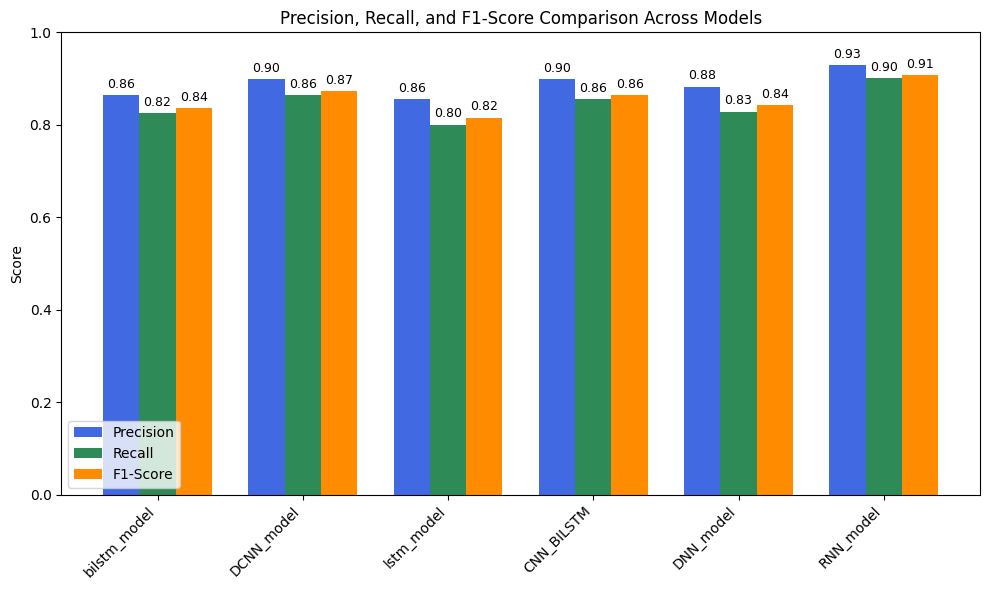

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']

# Extract Precision, Recall, and F1-Score for each model from results_test
precisions = [results_test[model]['Precision'] for model in model_names]
recalls = [results_test[model]['Recall'] for model in model_names]
f1_scores = [results_test[model]['F1-Score'] for model in model_names]

# Define positions and width for the bars
x = np.arange(len(model_names))  # Position of each model
width = 0.25  # Width of each bar

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Precision, Recall, and F1-Score
bars1 = ax.bar(x - width, precisions, width, label='Precision', color='royalblue')
bars2 = ax.bar(x, recalls, width, label='Recall', color='seagreen')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='darkorange')

# Add labels, title, and customize x-axis
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score Comparison Across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)  # Since Precision, Recall, and F1-Score are between 0 and 1
ax.legend()

# Function to annotate bars with values
def autolabel(bars):
    """Attach a text label above each bar displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', fontsize=9)

# Apply annotation function to each set of bars
for bars in [bars1, bars2, bars3]:
    autolabel(bars)

# Show plot
plt.tight_layout()
plt.show()


#### Optimization 

- implement Progressive Layer Freezing and Low-Rank Factorization

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

def build_optimized_model(sequence_length=60, no_features=10, num_classes=5):
    """Model with Low-Rank Factorization and Progressive Freezing support"""
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # CNN Block
        Conv1D(128, 5, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(64, 3, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.2),
        
        # BiLSTM Block
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # Classification Head with Low-Rank Factorization
        TimeDistributed(Dense(32, use_bias=False)),  # Reduced from 64
        TimeDistributed(Dense(64, activation='relu')),
        Dropout(0.1),
        TimeDistributed(Dense(16, use_bias=False)),  # Reduced from 5
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    return model

# Load your pretrained model (optional)
# base_model = load_model('models/CNN_BILSTM.keras')

# Build new optimized model
optimized_model = build_optimized_model()
optimized_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

class ProgressiveFreezer(tf.keras.callbacks.Callback):
    """Implements Progressive Layer Freezing"""
    def __init__(self, unfreeze_stages):
        super().__init__()
        self.stages = unfreeze_stages  # List of epoch numbers to unfreeze next stage
        self.current_stage = 0
        
    def on_epoch_begin(self, epoch, logs=None):
        if self.current_stage < len(self.stages) and epoch >= self.stages[self.current_stage]:
            print(f"\nUnfreezing stage {self.current_stage+1} layers")
            self._unfreeze_next_stage()
            self.current_stage += 1
            self.model.compile(optimizer=self.model.optimizer,
                             loss=self.model.loss,
                             metrics=self.model.metrics)
            
    def _unfreeze_next_stage(self):
        # Stage 0: Freeze all except classifier
        # Stage 1: Unfreeze BiLSTM layers
        # Stage 2: Unfreeze CNN layers
        
        if self.current_stage == 0:
            for layer in self.model.layers:
                if 'bidirectional' in layer.name:
                    layer.trainable = True
        elif self.current_stage == 1:
            for layer in self.model.layers:
                if 'conv1d' in layer.name:
                    layer.trainable = True

# Freeze all layers initially except classifier
for layer in optimized_model.layers[:-4]:  # Freeze everything except last 4 layers
    layer.trainable = False

# Training configuration
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ProgressiveFreezer(unfreeze_stages=[5, 10])  # Unfreeze BiLSTM at epoch 5, CNN at 10
]

history = optimized_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=2,  # Total epochs should cover all unfreeze stages
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

Epoch 1/2
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 142s 80ms/step - accuracy: 0.3326 - loss: 1.3432 - val_accuracy: 0.7714 - val_loss: 0.6535
Epoch 2/2
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 133s 79ms/step - accuracy: 0.4567 - loss: 1.1115 - val_accuracy: 0.7925 - val_loss: 0.6225
